## Introduction

You'll work with housing data for the city of Ames, Iowa, United States from 2006 to 2010. You can read more about why the data was collected [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627). You can also read about the different columns in the data [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [2]:
houses = pd.read_csv('AmesHousing.tsv', delimiter = '\t')
houses. head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
def transform_features(data):
    return data

def select_features(data):
    return data[['Gr Liv Area', 'SalePrice']]

def train_and_test(data):
    train = data.iloc[:1460]
    test = data.iloc[1460:]
    
    numeric_train = train.select_dtypes(include = ['int', 'float'])
    numeric_test = test.select_dtypes(include = ['int', 'float'])
    
    target = 'SalePrice'
    features = numeric_train.columns.drop(target)
    
    lr = LinearRegression()
    
    lr.fit(train[features], train[target])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test[target], predictions)
    rmse = mse ** 0.5
    
    return rmse

In [4]:
transformed = transform_features(houses)
filtered = select_features(transformed)
rmse = train_and_test(filtered)
rmse

57088.25161263909

## Feature Engineering



Let's now start removing features with many missing values, diving deeper into potential categorical features, and transforming text and numerical columns.

**First**, drop columns more than 5% of missing values.

In [5]:
nulls = houses.isnull().sum()
nulls_drop = nulls[nulls > len(houses)*0.05]
nulls_drop

Lot Frontage      490
Alley            2732
Fireplace Qu     1422
Garage Type       157
Garage Yr Blt     159
Garage Finish     159
Garage Qual       159
Garage Cond       159
Pool QC          2917
Fence            2358
Misc Feature     2824
dtype: int64

In [6]:
houses.drop(columns = nulls_drop.index, inplace = True)
houses.shape

(2930, 71)

**Second**, drop text columns with any missing values.

In [7]:
nulls_object = houses.select_dtypes(include = ['object']).isnull().sum()
nulls_object

MS Zoning          0
Street             0
Lot Shape          0
Land Contour       0
Utilities          0
Lot Config         0
Land Slope         0
Neighborhood       0
Condition 1        0
Condition 2        0
Bldg Type          0
House Style        0
Roof Style         0
Roof Matl          0
Exterior 1st       0
Exterior 2nd       0
Mas Vnr Type      23
Exter Qual         0
Exter Cond         0
Foundation         0
Bsmt Qual         80
Bsmt Cond         80
Bsmt Exposure     83
BsmtFin Type 1    80
BsmtFin Type 2    81
Heating            0
Heating QC         0
Central Air        0
Electrical         1
Kitchen Qual       0
Functional         0
Paved Drive        0
Sale Type          0
Sale Condition     0
dtype: int64

In [8]:
nulls_object_drop = nulls_object[nulls_object > 0]
houses.drop(columns = nulls_object_drop.index, inplace = True)

In [9]:
houses.shape

(2930, 64)

**Third**, fix all remaining null values by filling them with most common value within the column.

In [10]:
nulls = houses.isnull().sum()
nulls_remains = nulls[nulls > 0]
nulls_remains

Mas Vnr Area      23
BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Bsmt Full Bath     2
Bsmt Half Bath     2
Garage Cars        1
Garage Area        1
dtype: int64

In [11]:
common_values = houses[nulls_remains.index].mode()
common_values

,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,Garage Cars,Garage Area
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [12]:
values_dict = common_values.to_dict('records')
values_dict

[{'Bsmt Full Bath': 0.0,
  'Bsmt Half Bath': 0.0,
  'Bsmt Unf SF': 0.0,
  'BsmtFin SF 1': 0.0,
  'BsmtFin SF 2': 0.0,
  'Garage Area': 0.0,
  'Garage Cars': 2.0,
  'Mas Vnr Area': 0.0,
  'Total Bsmt SF': 0.0}]

In [13]:
houses.fillna(values_dict[0], inplace = True)
houses.isnull().sum().value_counts()

0    64
dtype: int64

**Fourth**, create new features for better understanding, if possible.

In [14]:
houses['Years Before Sale'] = houses['Yr Sold'] - houses['Year Built']
houses['Years Since Remod'] = houses['Yr Sold'] - houses['Year Remod/Add']

In [15]:
negatives =  houses[(houses['Years Before Sale'] < 0) | (houses['Years Since Remod'] < 0)]
negatives

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Years Before Sale,Years Since Remod
1702,1703,528120010,60,RL,16659,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,6,2007,New,Partial,260116,0,-1
2180,2181,908154195,20,RL,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,17000,10,2007,New,Partial,183850,-1,-2
2181,2182,908154205,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,...,0,0,0,10,2007,New,Partial,184750,0,-1


In [16]:
negatives.index

Int64Index([1702, 2180, 2181], dtype='int64')

In [17]:
houses.drop(index = negatives.index, inplace = True) # rows with negative years are invalid

In [18]:
houses.drop(columns = ['Year Built', 'Year Remod/Add'], inplace = True) 
# original columns are no longer needed and doesn't help ML models

**Fifth**, drop columns that may leak information or not useful.

In [19]:
houses.drop(columns = ['PID', "Order"], inplace = True) #not useful
houses.drop(columns = ['Mo Sold', 'Sale Condition', 'Sale Type', 'Yr Sold'], inplace = True) # leaks data about the sale

- Updating the `transform_features()` function.

In [20]:
def transform_features(dataset):
    
    nulls = dataset.isnull().sum()
    nulls_over_5pct = nulls[nulls > len(dataset)*0.05]
    dataset.drop(columns = nulls_over_5pct.index, inplace = True)
    
    nulls_object = dataset.select_dtypes(include = ['object']).isnull().sum()
    nulls_object_drop = nulls_object[nulls_object > 0]
    dataset.drop(columns = nulls_object_drop.index, inplace = True)
    
    nulls_remain = dataset.isnull().sum()
    nulls_remain_edit = nulls_remain[nulls_remain > 0]
    mode_dict = dataset[nulls_remain_edit.index].mode().to_dict('records')[0]
    dataset.fillna(mode_dict, inplace =True)
    
    dataset['Years Before Sale'] = dataset['Yr Sold'] - dataset['Year Built']
    dataset['Years Since Remod'] = dataset['Yr Sold'] - dataset['Year Remod/Add']
    invalid = dataset[(dataset['Years Before Sale'] < 0) | (dataset['Years Since Remod'] < 0)]
    dataset.drop(index = invalid.index, inplace = True)
    
    dataset.drop(columns = ['PID', 'Order', 'Mo Sold', 'Sale Condition', 
                            'Sale Type', 'Yr Sold', 'Year Remod/Add', 'Year Built'], inplace = True)
    
    return dataset

In [21]:
houses = pd.read_csv('AmesHousing.tsv', delimiter = '\t')
transformed = transform_features(houses)
filtered = select_features(transformed)
rmse = train_and_test(filtered)

rmse

55275.36731241307

## Feature Selection

In [22]:
import seaborn as sns
%matplotlib inline

In [23]:
numerical_cols = houses.select_dtypes(include = ['float', 'int'])
numerical_corr = numerical_cols.corr()

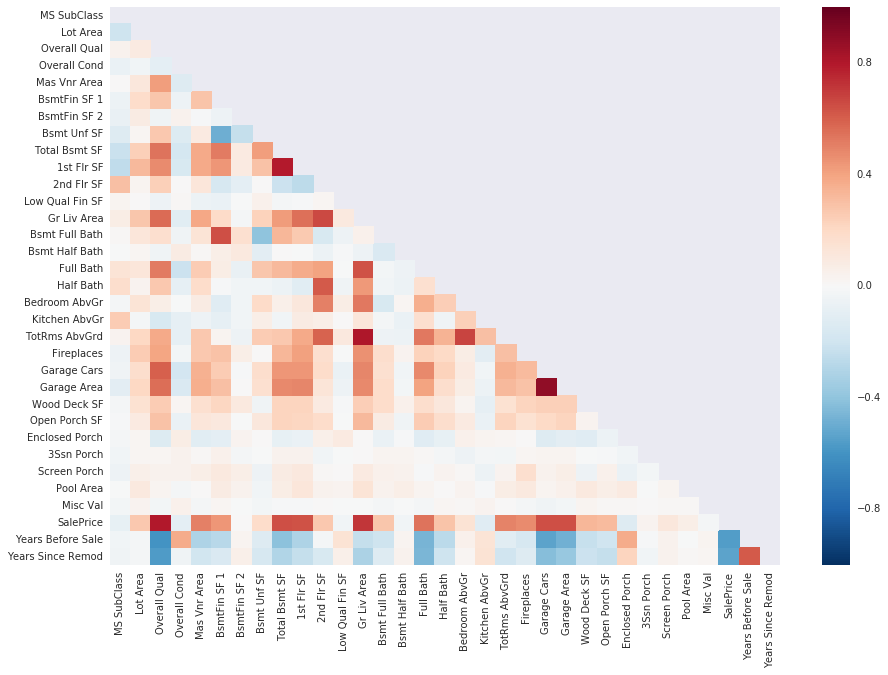

In [24]:
matrix = np.triu(numerical_corr)

f, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(numerical_corr, mask = matrix)

We are interested in the features that correlate strongly with `SalePrice` regardless of positive or negative correlation.
Let's compile the numerical values of the correlations.

In [25]:
saleprice_corr = numerical_corr['SalePrice'].abs().sort_values(ascending = False)
saleprice_corr

SalePrice            1.000000
Overall Qual         0.801206
Gr Liv Area          0.717596
Garage Cars          0.648361
Total Bsmt SF        0.644012
Garage Area          0.641425
1st Flr SF           0.635185
Years Before Sale    0.558979
Full Bath            0.546118
Years Since Remod    0.534985
Mas Vnr Area         0.506983
TotRms AbvGrd        0.498574
Fireplaces           0.474831
BsmtFin SF 1         0.439284
Wood Deck SF         0.328183
Open Porch SF        0.316262
Half Bath            0.284871
Bsmt Full Bath       0.276258
2nd Flr SF           0.269601
Lot Area             0.267520
Bsmt Unf SF          0.182751
Bedroom AbvGr        0.143916
Enclosed Porch       0.128685
Kitchen AbvGr        0.119760
Screen Porch         0.112280
Overall Cond         0.101540
MS SubClass          0.085128
Pool Area            0.068438
Low Qual Fin SF      0.037629
Bsmt Half Bath       0.035875
3Ssn Porch           0.032268
Misc Val             0.019273
BsmtFin SF 2         0.006127
Name: Sale

In [26]:
features_to_keep = saleprice_corr[saleprice_corr > 0.4]
features_to_keep

SalePrice            1.000000
Overall Qual         0.801206
Gr Liv Area          0.717596
Garage Cars          0.648361
Total Bsmt SF        0.644012
Garage Area          0.641425
1st Flr SF           0.635185
Years Before Sale    0.558979
Full Bath            0.546118
Years Since Remod    0.534985
Mas Vnr Area         0.506983
TotRms AbvGrd        0.498574
Fireplaces           0.474831
BsmtFin SF 1         0.439284
Name: SalePrice, dtype: float64

In [27]:
features_to_drop = saleprice_corr[saleprice_corr < 0.4]
transformed.drop(columns = features_to_drop.index, inplace = True)
transformed.head()

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,...,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,SalePrice,Years Before Sale,Years Since Remod
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,TA,7,Typ,2,2.0,528.0,P,215000,50,50
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,...,TA,5,Typ,0,1.0,730.0,Y,105000,49,49
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,Gd,6,Typ,0,1.0,312.0,Y,172000,52,52
3,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,Ex,8,Typ,2,2.0,522.0,Y,244000,42,42
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,TA,6,Typ,1,2.0,482.0,Y,189900,13,12


In [28]:
## Create a list of column names from documentation 
## that are *meant* to be categorical
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", 
                    "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", 
                    "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", 
                    "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

In [29]:
transform_cat_cols = []
for col in nominal_features:
    if col in transformed.columns:
        transform_cat_cols.append(col)
        
transform_cat_cols

['MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Foundation',
 'Heating',
 'Central Air']

In [30]:
unique_values = []
for col in transform_cat_cols:
    uv = len(transformed[col].value_counts())
    unique_values.append(uv)
unique_values

[7, 2, 4, 5, 28, 9, 8, 5, 8, 6, 8, 16, 17, 6, 6, 2]

In [31]:
unique_val_cols = pd.DataFrame(index = transform_cat_cols)
unique_val_cols['unique_vals'] = unique_values
unique_val_cols.sort_values(by = 'unique_vals', ascending = False)

,unique_vals
Neighborhood,28
Exterior 2nd,17
Exterior 1st,16
Condition 1,9
Condition 2,8
House Style,8
Roof Matl,8
MS Zoning,7
Roof Style,6
Foundation,6


In [32]:
drop_cols = unique_val_cols[unique_val_cols['unique_vals'] >10]
transformed.drop(columns = drop_cols.index, inplace = True)

In [33]:
# all the remaining "categorical" features
try:
    unique_val_cols.drop(index = drop_cols.index, inplace = True)
except:
    pass
unique_val_cols.sort_values(by = 'unique_vals')

,unique_vals
Street,2
Central Air,2
Land Contour,4
Lot Config,5
Bldg Type,5
Roof Style,6
Foundation,6
Heating,6
MS Zoning,7
Condition 2,8


In [34]:
drop_cols_2 = []
for col in unique_val_cols.index:
    col_uv = transformed[col].value_counts(normalize = True, ascending = False)
    if col_uv[0] > 0.95:
        drop_cols_2.append(col)
        
drop_cols_2

['Street', 'Condition 2', 'Roof Matl', 'Heating']

In [35]:
transformed.drop(columns = drop_cols_2, inplace = True)

In [36]:
object_cols = transformed.select_dtypes(include = ['object']).columns
dummy_col = pd.DataFrame()

for col in object_cols:
    transformed[col]  = transformed[col].astype('category')
    dummy_col = pd.get_dummies(transformed[col])
    transformed = pd.concat([transformed, dummy_col], axis = 1)
    transformed.drop(columns = col, inplace = True)

We dropped all columns:

- with over 10 unique values because an enormous amount of dummy columns would need to added if we keep them.
- where 95% of the values belonged in a specfic category, which has no variablity in the data for the model to capture.

We created dummy columns for all the remaining categorical columns and dropped the original columns.

In [37]:
# updating select_features()

def select_features(data, coeff_cutoff = 0.4, vals = 10, category_var = 0.95):
    
    numerical_cols = data.select_dtypes(include = ['float', 'int'])
    numerical_corr = numerical_cols.corr()
    saleprice_corr = numerical_corr['SalePrice'].abs().sort_values()
    features_to_drop = saleprice_corr[saleprice_corr < 0.4]
    data = data.drop(columns = features_to_drop.index)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", 
                    "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", 
                    "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", 
                    "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    transform_cat_cols = []
    for col in nominal_features:
        if col in data.columns:
            transform_cat_cols.append(col)
    unique_values = []
    for col in transform_cat_cols:
        uv = len(data[col].value_counts())
        unique_values.append(uv)
        
    unique_val_df = pd.DataFrame(index = transform_cat_cols)
    unique_val_df['unique_values'] = unique_values
    drop_cols = unique_val_df[unique_val_df['unique_values'] > vals]
    data = data.drop(columns = drop_cols.index)
    
    unique_val_df.drop(index = drop_cols.index, inplace = True)
    drop_cols_2 = []
    for col in unique_val_df.index:
        col_uv = data[col].value_counts(normalize = True, ascending = False)
        if col_uv[0] > category_var:
            drop_cols_2.append(col)
    data = data.drop(columns = drop_cols_2)
    
    object_cols = data.select_dtypes(include = ['object'])
    dummy_cols = pd.DataFrame()
    for col in object_cols:
        data[col] = data[col].astype('category')
        dummy_cols = pd.get_dummies(data[col])
        data = pd.concat([data, dummy_cols], axis = 1)
        data = data.drop(columns = col)
        
    return data

## Train & Test

We will be updating `train_and_test()` to include cross validation.

In [38]:
def train_and_test(data, k = 0):
    
    numeric_data = data.select_dtypes(include = ['float', 'int'])
    target = 'SalePrice'
    features = numeric_data.columns.drop(target)
    lr = LinearRegression()
    
    
    if k == 0:
        train = numeric_data.iloc[:1460]
        test = numeric_data.iloc[1460:]
    
        lr.fit(train[features], train[target])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test[target], predictions)
        rmse = mse ** 0.5
    
        return rmse
    
    elif k == 1:
        shuffled_df = numeric_df.sample(frac = 1, random_state = 1)
        fold_one = shuffled_df.iloc[:1460]
        fold_two = shuffled_df.iloc[1460:]
        
        #train on fold_one & test on fold_two
        lr.fit(fold_one[features], fold_one[target])
        predictions = lr.predict(fold_two[features])
        mse = mean_squared_error(fold_two[target], predictions)
        rmse_one = mse ** 0.5
        
        #train on fold_two & test on fold_two
        lr.fit(fold_two[features], fold_two[target])
        predictions = lr.predict(fold_one[features])
        mse = mean_squared_error(fold_one[target], predictions)
        rmse_two = mse ** 0.5
        
        rmse = np.mean([rmse_one, rmse_two])
        
        return rmse
    
    else:
        rmses = []
        kf = KFold(n_splits = k, random_state = 1)
        
        for train_index, test_index in kf.split(data):
            train, test = data.iloc[train_index], data.iloc[test_index]
            lr.fit(train[features], train[target])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test[target], predictions)
            rmse = mse ** 0.5
            rmses.append(rmse)
            
        return np.mean(rmses)

In [39]:
houses = pd.read_csv('AmesHousing.tsv', delimiter = '\t')
transformed = transform_features(houses)
filtered = select_features(transformed)
rmse = train_and_test(filtered, k = 5)

In [40]:
rmse

33327.32166216757

After feature engineering and feature selection, we were able to drop the rmse from `57088` to `55275` to finally `33327`.